<a href="https://colab.research.google.com/github/dmar10862/uoc_tipologia_y_ciclo_de_vida_de_los_datos_practica_2/blob/develop/src/UOC_M2851_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Practica 2: Limpieza y análisis de datos**

M2851 - Tipología y ciclo de vida de los datos

Ciencia de Datos

**David Marín Sánchez**

Junio 2020

**Kaggle Competition**

[Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic/overview)

https://www.kaggle.com/ouyangg/titanic

# Hyperparametros


In [0]:
# Limpieza
age_categories = 10
fare_categories = 10
dimensions_removed = 0

# Modelado
neurons = 32
lr = 0.0002
epochs = 200
batch_size = 1
patience = 10

# Librerias

https://github.com/Kaggle/kaggle-api

In [2]:
from google.colab import drive
from google.colab import auth
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import isnan
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LinearRegression, LogisticRegression
from scipy import stats
import statsmodels.api as sm
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Descargar dataset de Kaggle

In [3]:
# Montar Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
%%bash
# Instalar kaggle
pip install -q kaggle

# Cargar las credeciales de Kaggle
mkdir -p /root/.kaggle
cp -a "/content/drive/My Drive/Credentials/kaggle.json" /root/.kaggle/kaggle.json
ls -l /root/.kaggle

total 4
-rw------- 1 root root 64 May  9 08:42 kaggle.json


In [5]:
# Descargar dataset
%%bash
mkdir -p datasets
cd datasets
kaggle competitions download -c titanic
ls -la

train.csv: Skipping, found more recently modified local copy (use --force to force download)
gender_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
test.csv: Skipping, found more recently modified local copy (use --force to force download)
total 100
drwxr-xr-x 2 root root  4096 May 20 07:37 .
drwxr-xr-x 1 root root  4096 May 20 07:50 ..
-rw-r--r-- 1 root root  3258 May 20 07:37 gender_submission.csv
-rw-r--r-- 1 root root 28629 May 20 07:37 test.csv
-rw-r--r-- 1 root root 61194 May 20 07:37 train.csv


# Cargar Datos

In [0]:
# Cargar dataset como Pandas DataFrame
df_train = pd.read_csv('datasets/train.csv', index_col = 'PassengerId') 

In [0]:
# Separar las caracteristicas de la variable a estimar
X_train = df_train.copy()
y_train = X_train[['Survived']]
X_train = X_train.drop(columns=['Survived'])

In [8]:
display(X_train.shape)
display(X_train.count())
display(X_train.head())
display(y_train.shape)
display(y_train.count())
display(y_train.head())

(891, 10)

Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
dtype: int64

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


(891, 1)

Survived    891
dtype: int64

,Survived
PassengerId,
1,0
2,1
3,1
4,1
5,0


In [0]:
# Cargar dataset de test
df_test = pd.read_csv('datasets/test.csv', index_col='PassengerId') 
X_test = df_test.copy()

In [10]:
display(X_test.shape)
display(X_test.count())
display(X_test.head())

(418, 10)

Pclass      418
Name        418
Sex         418
Age         332
SibSp       418
Parch       418
Ticket      418
Fare        417
Cabin        91
Embarked    418
dtype: int64

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Limpieza de datos y análisis estadístico descriptivo

## Extraer nuevas carcaterísticas (Fetature Engineering)

In [11]:
# https://www.kaggle.com/ouyangg/titanic
X_train['Title'] = X_train['Name'].str.extract('([A-Za-z]+)\.')
X_train['Title'], title = pd.factorize(X_train['Title'])
X_train['Title'] = X_train['Title'].replace(-1, np.nan)
title = {k:v for v, k in enumerate(title)}
print(title)

X_test['Title'] = X_test['Name'].str.extract('([A-Za-z]+)\.')
X_test['Title'] = X_test['Title'].map(title)

{'Mr': 0, 'Mrs': 1, 'Miss': 2, 'Master': 3, 'Don': 4, 'Rev': 5, 'Dr': 6, 'Mme': 7, 'Ms': 8, 'Major': 9, 'Lady': 10, 'Sir': 11, 'Mlle': 12, 'Col': 13, 'Capt': 14, 'Countess': 15, 'Jonkheer': 16}


In [12]:
display(X_train.count())
display(X_train.head())
display(X_test.count())
display(X_test.head())

Pclass      891
Name        891
Sex         891
Age         714
SibSp       891
Parch       891
Ticket      891
Fare        891
Cabin       204
Embarked    889
Title       891
dtype: int64

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1
3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,1
5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0


Pclass      418
Name        418
Sex         418
Age         332
SibSp       418
Parch       418
Ticket      418
Fare        417
Cabin        91
Embarked    418
Title       417
dtype: int64

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,
892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1.0
894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1.0


## Eliminación de características

In [0]:
# Deajar solo variables útiles
X_train = X_train.drop(columns=['Name', 'Ticket', 'Cabin'])
X_test = X_test.drop(columns=['Name', 'Ticket', 'Cabin'])

In [14]:
display(X_train.count())
display(X_test.count())

Pclass      891
Sex         891
Age         714
SibSp       891
Parch       891
Fare        891
Embarked    889
Title       891
dtype: int64

Pclass      418
Sex         418
Age         332
SibSp       418
Parch       418
Fare        417
Embarked    418
Title       417
dtype: int64

## Factorizar (de texto a categorias)

In [15]:
# Convertir variables en numéricas
X_train['Sex'], sex = pd.factorize(X_train['Sex'])
X_train['Sex'] = X_train['Sex'].replace(-1, np.nan)
sex = {k:v for v, k in enumerate(sex)}
print(sex)
X_test['Sex'] = X_test['Sex'].map(sex)

X_train['Embarked'], embarked = pd.factorize(X_train['Embarked'])
X_train['Embarked'] = X_train['Embarked'].replace(-1, np.nan)
embarked = {k:v for v, k in enumerate(embarked)}
print(embarked)
X_test['Embarked'] = X_test['Embarked'].map(embarked)

{'male': 0, 'female': 1}
{'S': 0, 'C': 1, 'Q': 2}


In [16]:
display(X_train.head())
display(X_train.describe())
display(X_test.head())
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,22.0,1,0,7.2500,0.0,0
2,1,1,38.0,1,0,71.2833,1.0,1
3,3,1,26.0,0,0,7.9250,0.0,2
4,1,1,35.0,1,0,53.1000,0.0,1
5,3,0,35.0,0,0,8.0500,0.0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000,891.000000
mean,2.308642,0.352413,29.699118,0.523008,0.381594,32.204208,0.362205,0.936027
std,0.836071,0.477990,14.526497,1.102743,0.806057,49.693429,0.636157,1.725341
min,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,20.125000,0.000000,0.000000,7.910400,0.000000,0.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,3.000000,1.000000,38.000000,1.000000,0.000000,31.000000,1.000000,2.000000
max,3.000000,1.000000,80.000000,8.000000,6.000000,512.329200,2.000000,16.000000


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,34.5,0,0,7.8292,2,0.0
893,3,1,47.0,1,0,7.0000,0,1.0
894,2,0,62.0,0,0,9.6875,2,0.0
895,3,0,27.0,0,0,8.6625,0,0.0
896,3,1,22.0,1,1,12.2875,0,1.0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000,418.000000,417.000000
mean,2.265550,0.363636,30.272590,0.447368,0.392344,35.627188,0.464115,0.817746
std,0.841838,0.481622,14.181209,0.896760,0.981429,55.907576,0.685516,1.371191
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,21.000000,0.000000,0.000000,7.895800,0.000000,0.000000
50%,3.000000,0.000000,27.000000,0.000000,0.000000,14.454200,0.000000,0.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.500000,1.000000,2.000000
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200,2.000000,13.000000


## Discretizar características (de numeros a segmentos)

In [17]:
if age_categories > 0:
  X_train['Age'] = pd.qcut(X_train['Age'], age_categories)
  X_train['Age'], age = pd.factorize(X_train['Age'])
  X_train['Age'] = X_train['Age'].replace(-1, np.nan)
  age = {k:v for v, k in enumerate(age)}
  print(age)

{Interval(19.0, 22.0, closed='right'): 0, Interval(36.0, 41.0, closed='right'): 1, Interval(25.0, 28.0, closed='right'): 2, Interval(31.8, 36.0, closed='right'): 3, Interval(50.0, 80.0, closed='right'): 4, Interval(0.419, 14.0, closed='right'): 5, Interval(28.0, 31.8, closed='right'): 6, Interval(14.0, 19.0, closed='right'): 7, Interval(41.0, 50.0, closed='right'): 8, Interval(22.0, 25.0, closed='right'): 9}


In [0]:
if age_categories > 0:
  _list = []
  for i, x in enumerate(list(X_test['Age'])):
    found = False
    for k, v in age.items():
      try:
        if x in k:
          _list.append(v)
          found = True
          break
      except:
        pass
    if not found:
      _list.append(np.nan)

  X_test['Age'] = _list

In [19]:
if fare_categories > 0:
  X_train['Fare'] = pd.qcut(X_train['Fare'], fare_categories)
  X_train['Fare'], fare = pd.factorize(X_train['Fare'])
  X_train['Fare'] = X_train['Fare'].replace(-1, np.nan)
  fare = {k:v for v, k in enumerate(fare)}
  print(fare)

{Interval(-0.001, 7.55, closed='right'): 0, Interval(39.688, 77.958, closed='right'): 1, Interval(7.854, 8.05, closed='right'): 2, Interval(8.05, 10.5, closed='right'): 3, Interval(14.454, 21.679, closed='right'): 4, Interval(10.5, 14.454, closed='right'): 5, Interval(27.0, 39.688, closed='right'): 6, Interval(21.679, 27.0, closed='right'): 7, Interval(7.55, 7.854, closed='right'): 8, Interval(77.958, 512.329, closed='right'): 9}


In [0]:
if fare_categories > 0:
  _list = []
  for i, x in enumerate(list(X_test['Fare'])):
    found = False
    for k, v in fare.items():
      try:
        if x in k:
          _list.append(v)
          found = True
          break
      except:
        pass
    if not found:
      _list.append(np.nan)

  X_test['Fare'] = _list

In [21]:
display(X_train.head())
display(X_train.describe())
display(X_test.head())
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
1,3,0,0.0,1,0,0,0.0,0
2,1,1,1.0,1,0,1,1.0,1
3,3,1,2.0,0,0,2,0.0,2
4,1,1,3.0,1,0,1,0.0,1
5,3,0,3.0,0,0,2,0.0,0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000,889.000000,891.000000
mean,2.308642,0.352413,4.689076,0.523008,0.381594,4.438833,0.362205,0.936027
std,0.836071,0.477990,2.819232,1.102743,0.806057,2.887286,0.636157,1.725341
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,3.000000,0.000000,5.000000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,3.000000,1.000000,7.000000,1.000000,0.000000,7.000000,1.000000,2.000000
max,3.000000,1.000000,9.000000,8.000000,6.000000,9.000000,2.000000,16.000000


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,
892,3,0,3.0,0,0,8.0,2,0.0
893,3,1,8.0,1,0,0.0,0,1.0
894,2,0,4.0,0,0,3.0,2,0.0
895,3,0,2.0,0,0,3.0,0,0.0
896,3,1,0.0,1,1,5.0,0,1.0


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,330.000000,418.000000,418.000000,416.000000,418.000000,417.000000
mean,2.265550,0.363636,4.642424,0.447368,0.392344,4.574519,0.464115,0.817746
std,0.841838,0.481622,3.008502,0.896760,0.981429,2.918858,0.685516,1.371191
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,2.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,3.000000,0.000000,5.000000,0.000000,0.000000,5.000000,0.000000,0.000000
75%,3.000000,1.000000,7.000000,1.000000,0.000000,7.000000,1.000000,2.000000
max,3.000000,1.000000,9.000000,8.000000,9.000000,9.000000,2.000000,13.000000


## Valores perdidos

In [0]:
# https://scikit-learn.org/stable/modules/impute.html
# https://scikit-learn.org/dev/modules/generated/sklearn.impute.KNNImputer.html

# Se asigna a la variable imp un objeto del tipo KNNImputer
imp = KNNImputer().fit(X_train)

# Se aplica la transformación para cada atributo
X_train = pd.DataFrame(imp.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(imp.transform(X_test), columns = X_test.columns)

In [23]:
display(X_train.describe())
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,4.685971,0.523008,0.381594,4.438833,0.362963,0.936027
std,0.836071,0.477990,2.554664,1.102743,0.806057,2.887286,0.635661,1.725341
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,3.000000,0.000000,5.000000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,3.000000,1.000000,7.000000,1.000000,0.000000,7.000000,1.000000,2.000000
max,3.000000,1.000000,9.000000,8.000000,6.000000,9.000000,2.000000,16.000000


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.363636,4.669378,0.447368,0.392344,4.580861,0.464115,0.820096
std,0.841838,0.481622,2.704729,0.896760,0.981429,2.915142,0.685516,1.370388
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,3.000000,0.000000,4.900000,0.000000,0.000000,5.000000,0.000000,0.000000
75%,3.000000,1.000000,7.000000,1.000000,0.000000,7.000000,1.000000,1.950000
max,3.000000,1.000000,9.000000,8.000000,9.000000,9.000000,2.000000,13.000000


## Valores extremos

Añadir la opción de eliminar valore extermos o no

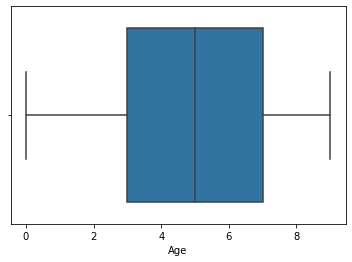

In [24]:
plot = sns.boxplot(X_train['Age']);

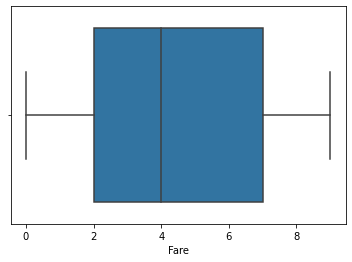

In [25]:
plot = sns.boxplot(X_train['Fare']);

## Reducción la dimensionalidad

Proporción de la variabilidad explicada por elos componentes: [0.40693, 0.31076, 0.14126, 0.06438, 0.029, 0.02244, 0.01688, 0.00835]


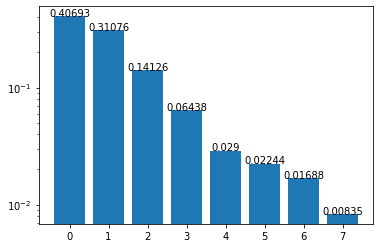

In [26]:
# https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
pca = PCA(n_components = len(X_train.columns)).fit(X_train)

# A) Proporción de la variabilidad explicada por el primer componente
print('Proporción de la variabilidad explicada por elos componentes: ' +
      str([round(value, 5) for value in pca.explained_variance_ratio_]))

# B) Diagrama de barras que representa la proporción de variabilidad explicada
# por los tres componentes más significativos

# Se genera una nueva figura
fig, ax = plt.subplots()
# Se representa el eje y en escala logarítmica para apreciar mejor la
# proporción de variabilidad explicada por los componentes menos significativos
ax.set_yscale('log')
# Se genera una gráfica de barras 
# https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.bar.html
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
# Se añade una etiqueta con el valor de la proporción de variabilidad explicada
for i, value in enumerate(pca.explained_variance_ratio_):
    plt.text(i, value, round(value,5), ha='center')
# Se muestra la gráfica
plt.show()

In [0]:
if dimensions_removed > 0:
  pca = PCA(n_components = len(X_train.columns) - dimensions_removed).fit(X_train)
  X_train = pd.DataFrame(pca.transform(X_train))
  X_test = pd.DataFrame(pca.transform(X_test))  

In [28]:
display(X_train.describe())
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,0.352413,4.685971,0.523008,0.381594,4.438833,0.362963,0.936027
std,0.836071,0.477990,2.554664,1.102743,0.806057,2.887286,0.635661,1.725341
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,3.000000,0.000000,5.000000,0.000000,0.000000,4.000000,0.000000,0.000000
75%,3.000000,1.000000,7.000000,1.000000,0.000000,7.000000,1.000000,2.000000
max,3.000000,1.000000,9.000000,8.000000,6.000000,9.000000,2.000000,16.000000


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.363636,4.669378,0.447368,0.392344,4.580861,0.464115,0.820096
std,0.841838,0.481622,2.704729,0.896760,0.981429,2.915142,0.685516,1.370388
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,0.000000,0.000000,2.000000,0.000000,0.000000
50%,3.000000,0.000000,4.900000,0.000000,0.000000,5.000000,0.000000,0.000000
75%,3.000000,1.000000,7.000000,1.000000,0.000000,7.000000,1.000000,1.950000
max,3.000000,1.000000,9.000000,8.000000,9.000000,9.000000,2.000000,13.000000


## Estandarización

In [0]:
# https://scikit-learn.org/stable/modules/neural_networks_supervised.html#mlp-tips
scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns = X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns = X_test.columns)

In [30]:
display(X_train.describe())
display(X_test.describe())

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02,8.910000e+02
mean,-2.031048e-16,3.162453e-16,-6.105604e-18,3.456519e-16,6.716164e-17,-1.993666e-17,6.678783e-17,2.367479e-17
std,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00,1.000562e+00
min,-1.566107e+00,-7.376951e-01,-1.835311e+00,-4.745452e-01,-4.736736e-01,-1.538235e+00,-5.713215e-01,-5.428218e-01
25%,-3.693648e-01,-7.376951e-01,-6.603286e-01,-4.745452e-01,-4.736736e-01,-8.451543e-01,-5.713215e-01,-5.428218e-01
50%,8.273772e-01,-7.376951e-01,1.229929e-01,-4.745452e-01,-4.736736e-01,-1.520733e-01,-5.713215e-01,-5.428218e-01
75%,8.273772e-01,1.355574e+00,9.063144e-01,4.327934e-01,-4.736736e-01,8.875481e-01,1.002728e+00,6.170204e-01
max,8.273772e-01,1.355574e+00,1.689636e+00,6.784163e+00,6.974147e+00,1.580629e+00,2.576777e+00,8.735916e+00


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,-0.051570,0.023493,-0.006499,-0.068631,0.013345,0.049219,0.159218,-0.067231
std,1.007462,1.008165,1.059336,0.813665,1.218251,1.010215,1.079036,0.794717
min,-1.566107,-0.737695,-1.835311,-0.474545,-0.473674,-1.538235,-0.571322,-0.542822
25%,-1.566107,-0.737695,-0.660329,-0.474545,-0.473674,-0.845154,-0.571322,-0.542822
50%,0.827377,-0.737695,0.083827,-0.474545,-0.473674,0.194467,-0.571322,-0.542822
75%,0.827377,1.355574,0.906314,0.432793,-0.473674,0.887548,1.002728,0.588024
max,0.827377,1.355574,1.689636,6.784163,10.698058,1.580629,2.576777,6.996152


# Análisis estadístico inferencial

## Normalidad y homocedasticidad

Añadir los que sobreviven vs los que no

Añadir alguna prueba estadística

In [0]:
def normality_test(X, variable):
  statistic, pvalue = stats.shapiro(X[variable])

  statistic = round(statistic, 6)
  pvalue = round(pvalue, 6)
  print('statistic = '+str(statistic))
  print('pvalue = '+str(pvalue))

  if pvalue < 0.05:
    print("La distribución no se ajusta a una distribución normal")
  if pvalue > 0.05:
    print("La distribución se ajusta a una distribución normal")
    
  plot = sns.distplot(X[variable]);

In [0]:
 def homoscedasticity_test(X, variable):
  statistic, pvalue = stats.fligner(X[X['Survived'] == 0][variable], X[X['Survived'] == 1][variable])

  statistic = round(statistic, 6)
  pvalue = round(pvalue, 6)
  print('statistic = '+str(statistic))
  print('pvalue = '+str(pvalue))

  if pvalue < 0.05:
    print("Las varianzas son significativamente difernetes")
  else:
    print("Las varianzas no son significativamente difernetes")

  plot = sns.catplot(x = variable, kind = "box", row = 'Survived', height = 4, data = X)

In [0]:
# Volver a unir las características con la clase a predecir
Xy_train = X_train.copy()
Xy_train['Survived'] = y_train

In [34]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Title'], dtype='object')

statistic = 0.961772
pvalue = 0.0
La distribución no se ajusta a una distribución normal


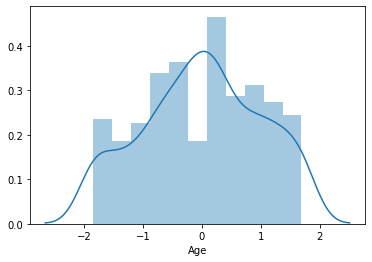

In [35]:
normality_test(Xy_train, 'Age')

statistic = 0.005528
pvalue = 0.940733
Las varianzas no son significativamente difernetes


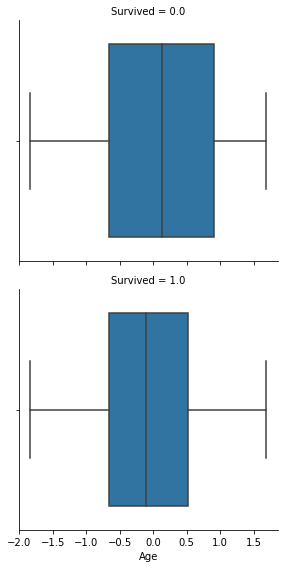

In [36]:
homoscedasticity_test(Xy_train, 'Age')

statistic = 0.933014
pvalue = 0.0
La distribución no se ajusta a una distribución normal


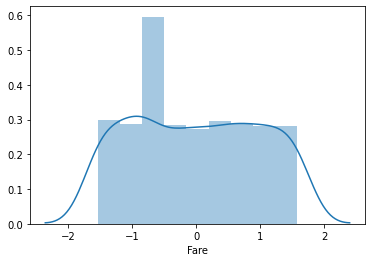

In [37]:
normality_test(Xy_train, 'Fare')

statistic = 3.554969
pvalue = 0.059367
Las varianzas no son significativamente difernetes


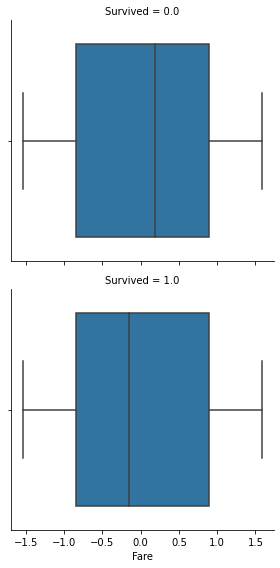

In [38]:
homoscedasticity_test(Xy_train, 'Fare')

## Análisis de correlación y regresión lineal

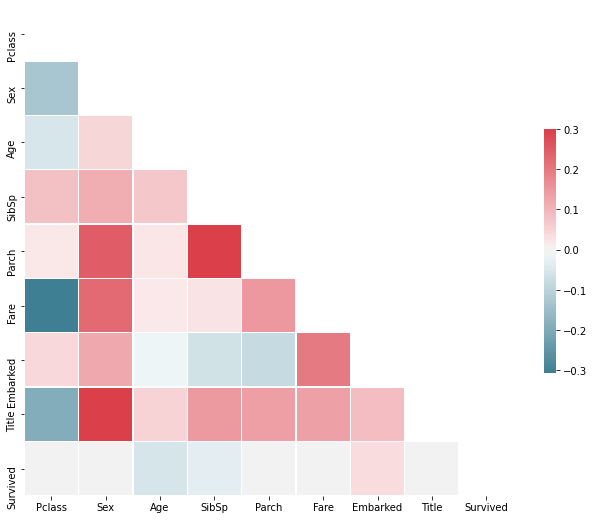

In [39]:
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
# Compute the correlation matrix
corr = Xy_train.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
plot = sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [40]:
model = sm.OLS(y_train.values.ravel(), X_train).fit()
display(model.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.235
Model:                            OLS   Adj. R-squared (uncentered):              0.228
Method:                 Least Squares   F-statistic:                              33.82
Date:                Wed, 20 May 2020   Prob (F-statistic):                    1.08e-46
Time:                        15:55:22   Log-Likelihood:                         -718.62
No. Observations:                 891   AIC:                                      1453.
Df Residuals:                     883   BIC:                                      1492.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Pclass        -0.1218      0.020     -6.147      0.000      -0.161      -0.083
Sex            0.2361      0.020     11.568      0.000       0.196       0.276
Age           -0.0025      0.018     -0.136      0.892      -0.038       0.033
SibSp         -0.0357      0.020     -1.757      0.079      -0.076       0.004
Parch         -0.0056      0.021     -0.270      0.788      -0.047       0.035
Fare           0.0094      0.020      0.467      0.640      -0.030       0.049
Embarked       0.0226      0.019      1.183      0.237      -0.015       0.060
Title          0.0355      0.020      1.773      0.076      -0.004       0.075
==============================================================================
Omnibus:                       38.955   Durbin-Watson:                   0.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               43.147
Skew:                           0.537   Prob(JB):                     4.27e-10
Kurtosis:                       3.095   Cond. No.                         1.91
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Análisis de Regresion

In [41]:
# Se genera un modelo de regresión logística a partir del subconjunto de 
# datos de entrenamiento
clf = LogisticRegression(solver = 'lbfgs')
clf.fit(X_train, y_train.values.ravel())

# Se valida el modelo comparando las predicciones realizadas a partir
# del subconjunto de datos de validación con los valores reales
y_pred = clf.predict(X_train)

train_acc = round(accuracy_score(y_train, y_pred, normalize=True),6)
cmatrix_train = confusion_matrix(y_train, y_pred)

print('Matriz de confusión del modelo:\n', cmatrix_train)
print('Precisión del modelo:', train_acc)

Matriz de confusión del modelo:
 [[477  72]
 [108 234]]
Precisión del modelo: 0.79798


# Aprendizaje automático

## Modelado

In [0]:
# ML Model train
# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
def train_ml_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle=True):
    # patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=patience)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True)

    # fit model
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=shuffle, callbacks=[es, mc])

    # load the saved model
    model = load_model('best_model.h5')

    # plot training history
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val')
    plt.legend()
    plt.show()
  
    # Estimate model performance
    trainScore = model.evaluate(X_train, y_train, batch_size=batch_size, verbose=0)
    valScore = model.evaluate(X_val, y_val, batch_size=batch_size, verbose=0)
  
    print('Train Loss: %.6f' % trainScore[0])
    print('Train Accuracy: %.6f' % trainScore[1])
    print('Val Loss: %.6f' % valScore[0])
    print('Val Accuracy: %.6f' % valScore[1])
  
    return model

In [0]:
# Entrenar Red neuronal densa
# https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/
# https://www.kaggle.com/parthsuresh/binary-classifier-using-keras-97-98-accuracy
# @tf.function
def dense_nn(X, y, epochs, batch_size, lr, patience, neurons, shuffle=True): 
  # Split test y val
  X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

  # Dimensiones
  n_input =  X_train.shape[1]
  n_output = y_train.shape[1]
  
  model = Sequential([
      Dense(n_input, input_dim=n_input, activation='relu'),
      Dense(neurons, activation='relu'),
      Dense(n_output, activation='sigmoid')
  ])
  
  model.compile(optimizer=Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])

  model = train_ml_model(model, X_train, y_train, X_val, y_val, epochs, batch_size, patience, shuffle)
  
  return model

In [0]:
# ML Model predict
def predict_with_ml_model(model, X, batch_size):
  y_pred = (model.predict(X, batch_size=batch_size) > 0.5).astype("int32")

  return y_pred

Epoch 1/200
801/801 [==============================] - 1s 1ms/step - loss: 0.6851 - accuracy: 0.5306 - val_loss: 0.6416 - val_accuracy: 0.6667
Epoch 2/200
801/801 [==============================] - 1s 1ms/step - loss: 0.6141 - accuracy: 0.6866 - val_loss: 0.6021 - val_accuracy: 0.7000
Epoch 3/200
801/801 [==============================] - 1s 1ms/step - loss: 0.5648 - accuracy: 0.7241 - val_loss: 0.5773 - val_accuracy: 0.7333
Epoch 4/200
801/801 [==============================] - 1s 1ms/step - loss: 0.5313 - accuracy: 0.7466 - val_loss: 0.5574 - val_accuracy: 0.7333
Epoch 5/200
801/801 [==============================] - 1s 1ms/step - loss: 0.5082 - accuracy: 0.7615 - val_loss: 0.5426 - val_accuracy: 0.7222
Epoch 6/200
801/801 [==============================] - 1s 1ms/step - loss: 0.4916 - accuracy: 0.7690 - val_loss: 0.5286 - val_accuracy: 0.7667
Epoch 7/200
801/801 [==============================] - 1s 1ms/step - loss: 0.4797 - accuracy: 0.7778 - val_loss: 0.5201 - val_accuracy: 0.7778

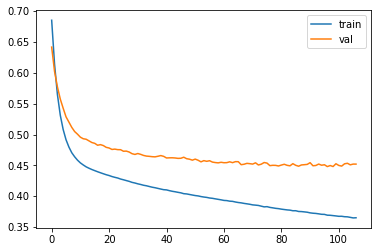

Train Loss: 0.366539
Train Accuracy: 0.842697
Val Loss: 0.448062
Val Accuracy: 0.822222


In [45]:
model = dense_nn(X_train, y_train, epochs=epochs, batch_size=batch_size, lr=lr, patience=patience, neurons=neurons)

In [46]:
# accuracy
y_pred = predict_with_ml_model(model, X_train, batch_size=batch_size)

train_acc = round(accuracy_score(y_train, y_pred, normalize=True),6)
cmatrix_train = confusion_matrix(y_train, y_pred)

print('Matriz de confusión del modelo:\n', cmatrix_train)
print('Precisión del modelo:', train_acc)

Matriz de confusión del modelo:
 [[508  41]
 [101 241]]
Precisión del modelo: 0.840629


In [47]:
# generate predictions for test
df_pred = pd.DataFrame(predict_with_ml_model(model, X_test, batch_size=batch_size), columns=['Survived'], index =  df_test.index)
  
display(df_pred.describe())
display(df_pred.head()) 
df_pred.to_csv('submission.csv', index=True)  

,Survived
count,418.000000
mean,0.363636
std,0.481622
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


,Survived
PassengerId,
892,0
893,1
894,0
895,0
896,0


# Subir resultados a Kaggle

In [49]:
%%bash
kaggle competitions submit -c titanic -f submission.csv -m "New submission test"

Successfully submitted to Titanic: Machine Learning from Disaster

100%|##########| 2.77k/2.77k [00:00<00:00, 10.7kB/s]
